# データの準備

In [1]:
import pandas as pd

# データの読み込み
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [2]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
# 日本語の感情
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼'] 

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)


## 感情強度が低いサンプルは除外

In [3]:
# 感情強度が低いサンプルは除外する (optional)
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [4]:
# 客観感情の平均（"Avg. Readers_*"）の列だけを抽出する
df_wrime_features = df_wrime_target.loc[:, 'Avg. Readers_Joy':'Avg. Readers_Trust']
df_wrime_features.info() # なぜ平均なのにint型？

<class 'pandas.core.frame.DataFrame'>
Index: 18237 entries, 0 to 43199
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Avg. Readers_Joy           18237 non-null  int64
 1   Avg. Readers_Sadness       18237 non-null  int64
 2   Avg. Readers_Anticipation  18237 non-null  int64
 3   Avg. Readers_Surprise      18237 non-null  int64
 4   Avg. Readers_Anger         18237 non-null  int64
 5   Avg. Readers_Fear          18237 non-null  int64
 6   Avg. Readers_Disgust       18237 non-null  int64
 7   Avg. Readers_Trust         18237 non-null  int64
dtypes: int64(8)
memory usage: 1.3 MB


## 正規化

In [5]:
'''
from sklearn import preprocessing

# 正規化 (optional)
mm = preprocessing.MinMaxScaler()
df_wrime_features= pd.DataFrame(mm.fit_transform(df_wrime_features), columns=df_wrime_features.columns)
df_wrime_features.info()
'''

'\nfrom sklearn import preprocessing\n\n# 正規化 (optional)\nmm = preprocessing.MinMaxScaler()\ndf_wrime_features= pd.DataFrame(mm.fit_transform(df_wrime_features), columns=df_wrime_features.columns)\ndf_wrime_features.info()\n'

# クラスタリング

In [6]:
from sklearn.cluster import KMeans

# クラスタリング

# k: クラスター数 (optional)
k = 6

# k-means法の実行
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_wrime_features)
# 各サンプルのクラスター番号を取得する
clusters = kmeansModel.labels_
# clustersに1を足すことで、クラスター番号を1から始める
clusters = clusters + 1

c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


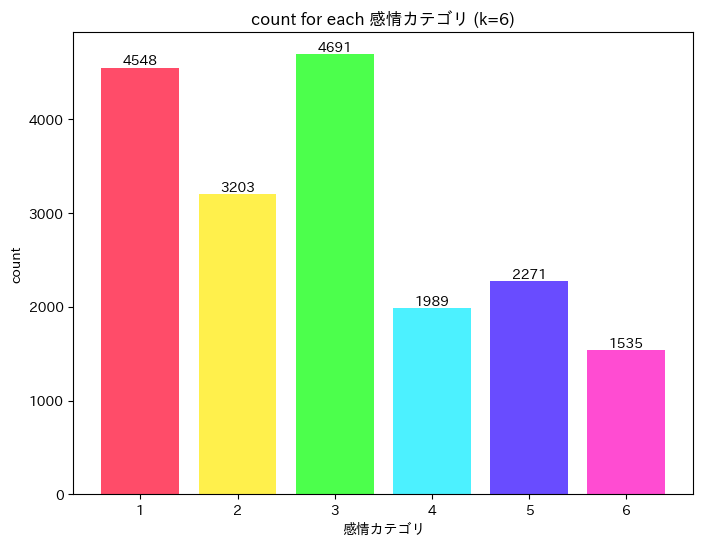

In [7]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
import numpy as np

# 日本語フォントの設定
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# 各クラスの度数を計算
unique_clusters, counts = np.unique(clusters, return_counts=True)

# カラーマップを取得
cmap_name = 'gist_rainbow'
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, len(unique_clusters)))

# 可視化
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_clusters, counts, color=colors, alpha=0.7)
plt.xlabel('感情カテゴリ')
plt.ylabel('count')
plt.title(f'count for each 感情カテゴリ (k={k})')
plt.xticks(unique_clusters)

# テキストを表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

## クラスター数の決定

In [8]:
k_max=40

### エルボー法による最適クラスター数の調査
エルボー法では、SSE値(残差平方和)が急激に減少している部分において、SSE値が最も小さい点が最適なクラスター数であると判断する

c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

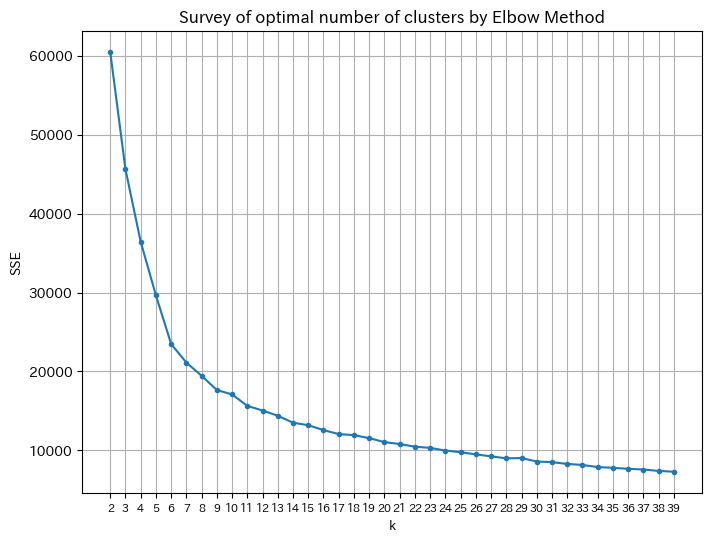

In [9]:

from sklearn.cluster import KMeans

# Survey of optimal number of clusters by Elbow Method
SSE = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)
    SSE.append(kmeans_model.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), SSE, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('SSE')
plt.title('Survey of optimal number of clusters by Elbow Method')
plt.grid(True)
plt.show()


### シルエット係数による最適クラスター数の調査

c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

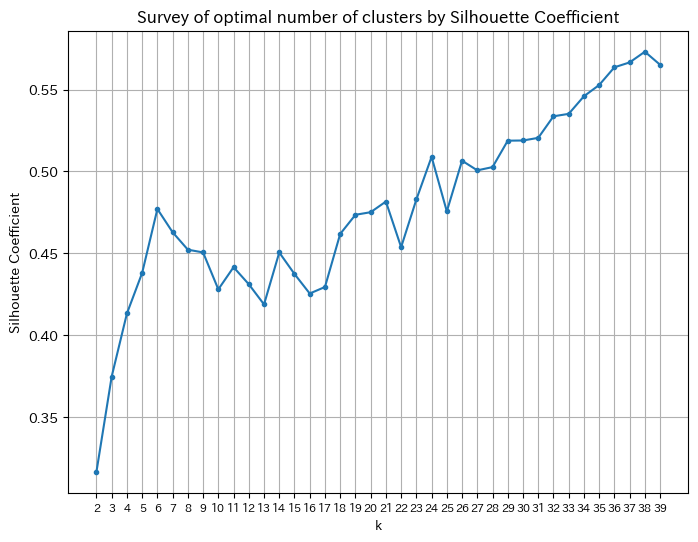

In [10]:

# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# # Survey of optimal number of clusters by Silhouette Coefficient
# silhouette_coefficients = []
# for i in range(2, k_max):
#     kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)
#     silhouette_coefficient = silhouette_score(df_wrime_features, kmeans_model.labels_) # シルエット係数の平均値
#     silhouette_coefficients.append(silhouette_coefficient)


# # 可視化
# plt.figure(figsize=(8, 6))
# plt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)
# plt.xlabel('k')
# plt.xticks(np.arange(2, k_max, 1), fontsize=8)
# plt.ylabel('Silhouette Coefficient')
# plt.title('Survey of optimal number of clusters by Silhouette Coefficient')
# plt.grid(True)
# plt.show()


c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\yossh\anaconda3\envs\preprocessing\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

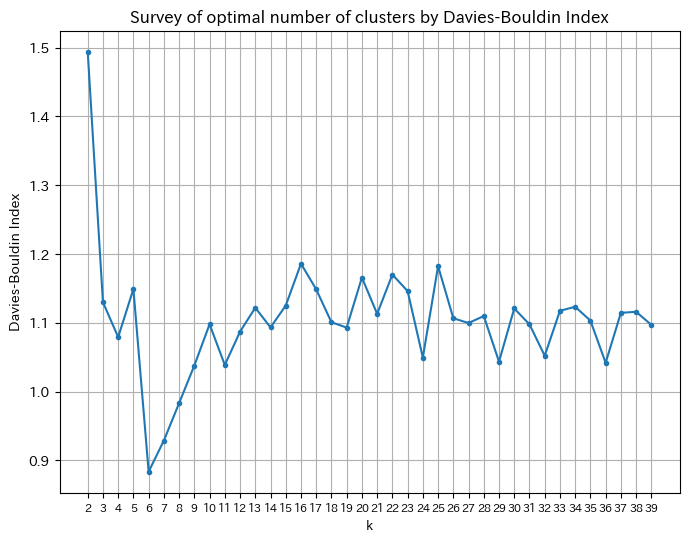

In [11]:
# Survey of optimal number of clusters by Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score

# クラスター数を変えて計算
dbi = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)
    dbi.append(davies_bouldin_score(df_wrime_features, kmeans_model.labels_))

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), dbi, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Davies-Bouldin Index')
plt.title('Survey of optimal number of clusters by Davies-Bouldin Index')
plt.grid(True)
plt.show()

### シルエット図

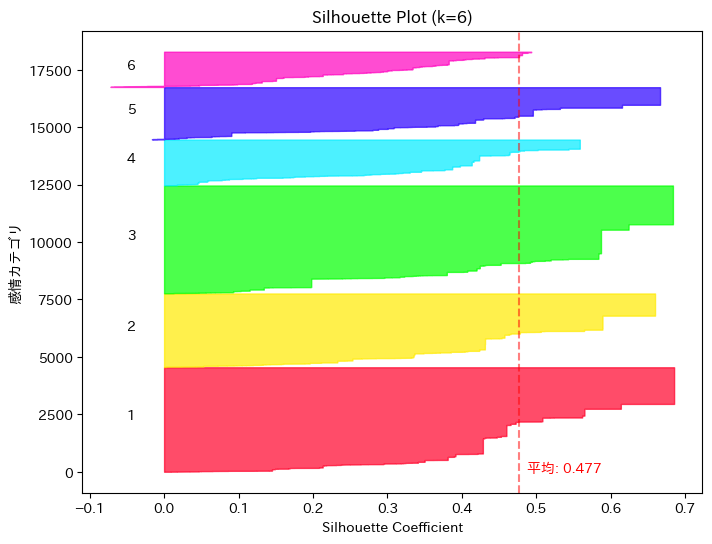

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_wrime_features, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_wrime_features, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i+1))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"average: {silhouette_avg:.3f}", color="red")

plt.xlabel('Silhouette Coefficient')
plt.ylabel('感情カテゴリ')
plt.title(f'Silhouette Plot (k={k})')
plt.show()

In [13]:
# 各感情カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'感情カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

感情カテゴリ: 1
シルエット係数が最も高い文章: やばい｡おもろいな?思ってみてみた「シャレードがいっぱい」｡よすぎるやん。
シルエット係数: 0.685
---
感情カテゴリ: 2
シルエット係数が最も高い文章: ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…
シルエット係数: 0.660
---
感情カテゴリ: 3
シルエット係数が最も高い文章: おなかすいた…夜ご飯仲間募集｡
シルエット係数: 0.684
---
感情カテゴリ: 4
シルエット係数が最も高い文章: 鬼滅クラスターあるな 
シルエット係数: 0.558
---
感情カテゴリ: 5
シルエット係数が最も高い文章: 西田辺は雷雨!!
シルエット係数: 0.666
---
感情カテゴリ: 6
シルエット係数が最も高い文章: これどうせジジババやんやろな(偏見) 
シルエット係数: 0.493
---


## クラスタリング結果の可視化

### PCA

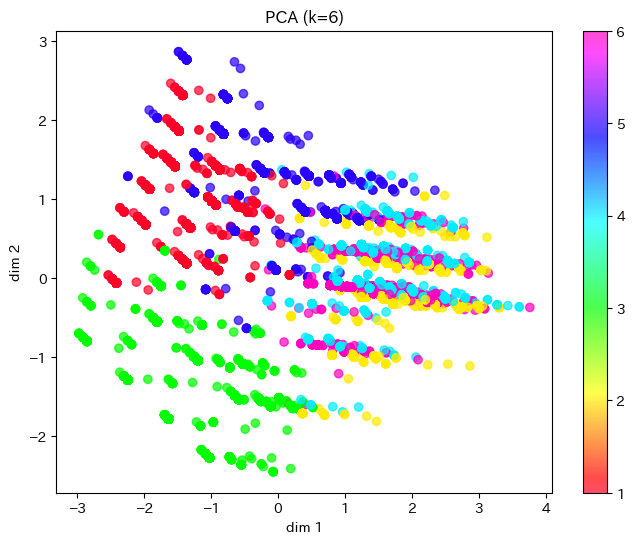

In [14]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca.fit(df_wrime_features)
df_wrime_features_pca = pca.transform(df_wrime_features)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_pca[:, 0], df_wrime_features_pca[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'PCA (k={k})')
plt.colorbar()
plt.show()

### t-SNE

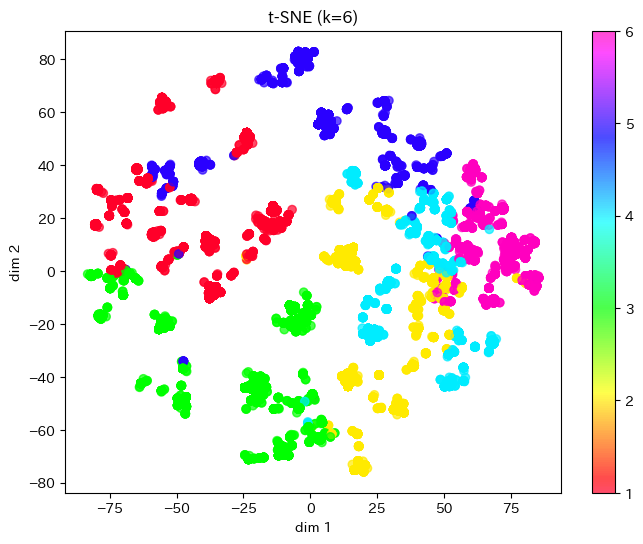

In [15]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
df_wrime_features_tsne = tsne.fit_transform(df_wrime_features)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={k})')
plt.colorbar()
plt.show()

### UMAP

In [16]:
'''
import umap

# UMAP
umap_obj = umap.UMAP(n_components=2, random_state=0, n_neighbors=50, metric='yule')
df_wrime_features_umap = umap_obj.fit_transform(df_wrime_features)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'UMAP (k={k})')
plt.colorbar()
plt.show()
'''

"\nimport umap\n\n# UMAP\numap_obj = umap.UMAP(n_components=2, random_state=0, n_neighbors=50, metric='yule')\ndf_wrime_features_umap = umap_obj.fit_transform(df_wrime_features)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)\nplt.xlabel('dim 1')\nplt.ylabel('dim 2')\nplt.title(f'UMAP (k={k})')\nplt.colorbar()\nplt.show()\n"

# アノテーション

## 各感情カテゴリと説明変数(8つの基本感情)の関係

### 下の図は 青色(弱い) ↔ 黄色(強い)で、各感情カテゴリと説明変数(8つの基本感情)の関係を示す。

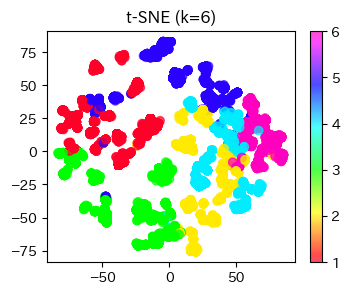

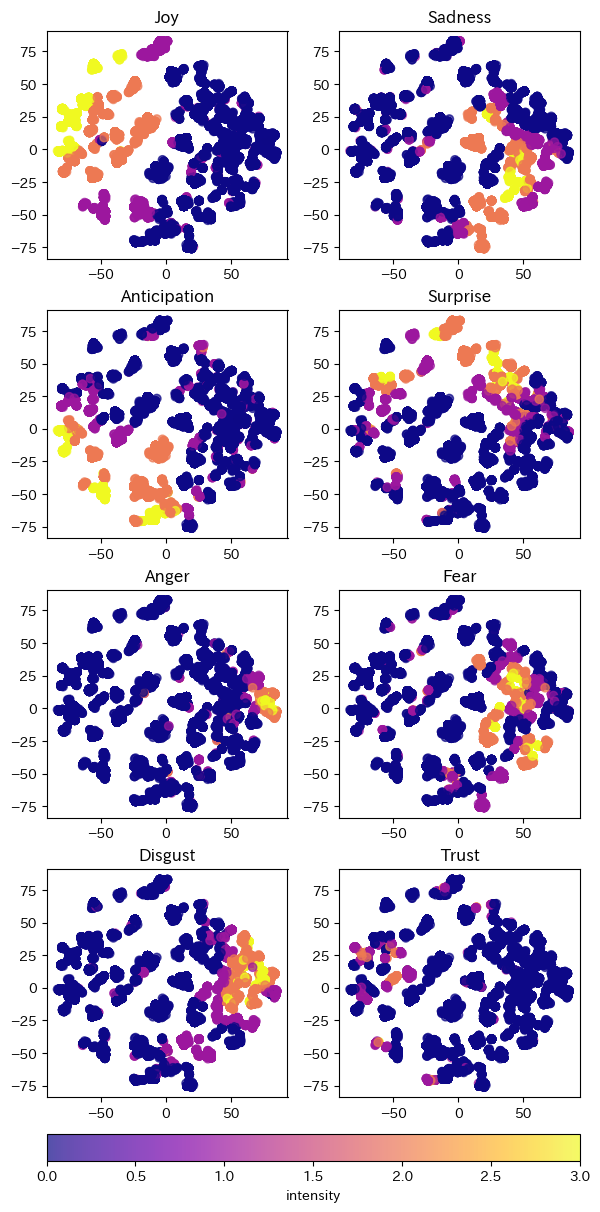

In [17]:
# UMAPによる可視化
plt.figure(figsize=(4, 3))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.title(f't-SNE (k={k})')
plt.colorbar()
plt.show()


# 説明変数の大小の可視化
fig = plt.figure(figsize=(6,13))
cols = df_wrime_features.columns
for i, col in enumerate(cols):
    ax = fig.add_subplot(4, 2, i+1, title=emotion_names[i])
    sc = ax.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1],
                    c=df_wrime_features[col], cmap='plasma', alpha=0.7)
fig.tight_layout()
fig.colorbar(sc, ax=fig.axes, orientation='horizontal', fraction=0.1, pad=0.03, label='intensity')

plt.show()

In [59]:
df_wrime_features_clusters.groupby(clusters).mean()

,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust
1,2.200748,0.021328,0.304969,0.304310,0.001759,0.015391,0.005717,0.222735
2,0.016547,2.123322,0.064939,0.198564,0.031221,0.315954,0.533250,0.004683
3,0.673204,0.052014,2.190578,0.054146,0.004263,0.043061,0.024302,0.071200
4,0.022624,0.595777,0.077426,0.420814,0.012569,2.160382,0.482152,0.006033
5,0.513430,0.095112,0.103479,2.185821,0.010568,0.158520,0.094672,0.067812
6,0.014332,0.410423,0.044951,0.256678,1.027362,0.328339,2.121824,0.001303


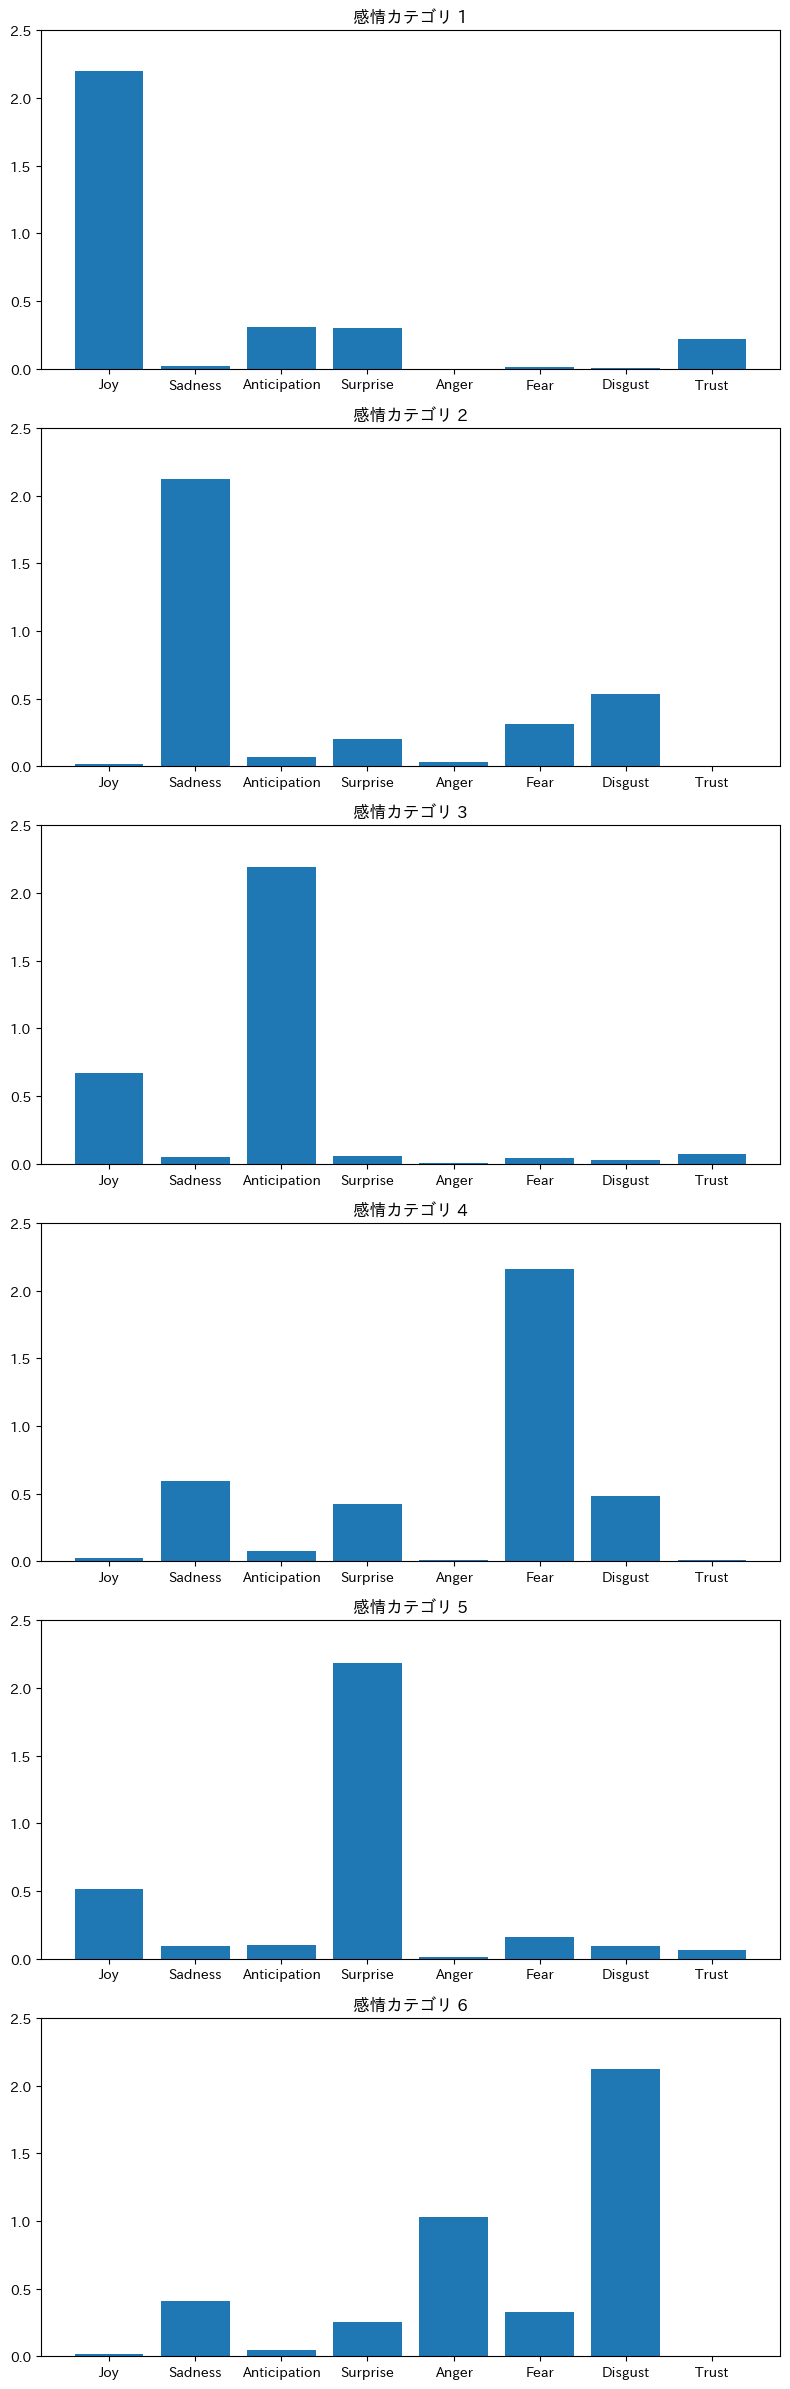

In [76]:
# データフレームを行ごとにサブプロットで表示するための設定
num_rows, num_cols = df_wrime_features_clusters.groupby(clusters).mean().shape
fig, axes = plt.subplots(num_rows, 1, figsize=(8, num_rows * 4))

# 行ごとにデータを取得し、各行に対して棒グラフを作成
for row_idx in range(num_rows):
    # row_data = df_wrime_features_clusters.groupby(clusters).mean().apply(np.log1p).iloc[row_idx, :]
    row_data = df_wrime_features_clusters.groupby(clusters).mean().iloc[row_idx, :]
    cluster_label = row_idx + 1

    # 各列の値を取得
    cluster_data = row_data.drop('cluster')
    column_names = cluster_data.index.tolist()
    column_values = cluster_data.values.tolist()

    # 棒グラフを作成
    axes[row_idx].bar(emotion_names, column_values)
    axes[row_idx].set_title(f'感情カテゴリ {cluster_label}')
    axes[row_idx].set_ylim(0, 2.5)

# レイアウトを調整して、グラフを表示
plt.tight_layout()
plt.show()

In [28]:
df_wrime_features_clusters = df_wrime_features.copy()
df_wrime_features_clusters['cluster'] = clusters
x = []
y = []
targets = []
colors = []
for i, col in enumerate(cols):
    for j in range(k+1):
        target_value = df_wrime_features_clusters[df_wrime_features_clusters['cluster']==j][col].mean()
        x.append(j)
        y.append(i)
        #targets.append(np.exp(1+target_value*3/2))
        targets.append(target_value*100)

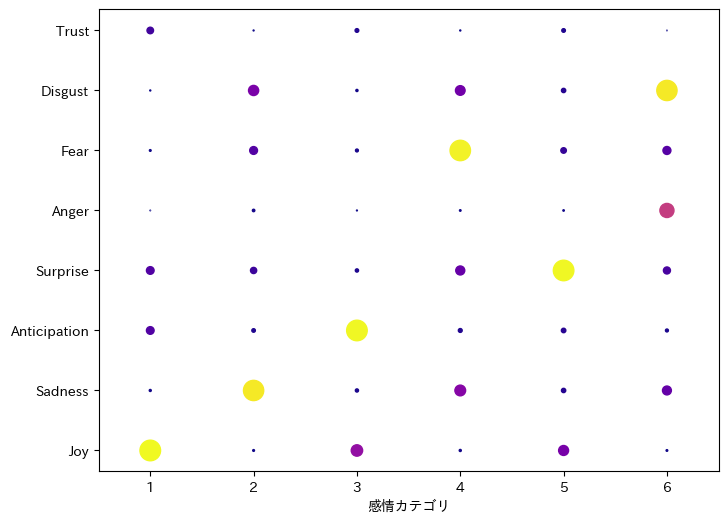

In [29]:

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x, y, s=targets, c=targets, cmap='plasma')
plt.xticks(list(range(k+1)), list(range(k+1)))
plt.yticks(list(range(len(cols))), emotion_names)
ax.set_xlim(+0.5, k+0.5)
plt.xlabel('感情カテゴリ')
plt.show()

In [19]:
# 各感情カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'感情カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

感情カテゴリ: 1
シルエット係数が最も高い文章: やばい｡おもろいな?思ってみてみた「シャレードがいっぱい」｡よすぎるやん。
シルエット係数: 0.685
---
感情カテゴリ: 2
シルエット係数が最も高い文章: ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…
シルエット係数: 0.660
---
感情カテゴリ: 3
シルエット係数が最も高い文章: おなかすいた…夜ご飯仲間募集｡
シルエット係数: 0.684
---
感情カテゴリ: 4
シルエット係数が最も高い文章: 鬼滅クラスターあるな 
シルエット係数: 0.558
---
感情カテゴリ: 5
シルエット係数が最も高い文章: 西田辺は雷雨!!
シルエット係数: 0.666
---
感情カテゴリ: 6
シルエット係数が最も高い文章: これどうせジジババやんやろな(偏見) 
シルエット係数: 0.493
---


In [20]:
# clustersを保存

# df_wrime_features_clusters['cluster'].to_csv('clusters/emotion_6clusters.tsv', sep='\t', header=False, index=None)
